In [1]:
import torch
import pickle
import os
from PIL import Image
from torch.nn.functional import softmax
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm
import torchvision.transforms as transforms
from IPython.utils import io
torch.set_printoptions(sci_mode=False)

## General Setup

In [2]:
# Products data and latents
target_feature = 'category'

In [3]:
import platform
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [4]:
os.chdir(f"{ROOT_PATH}/4_Assessor/Category_Assessor/DinoV2")
from helpers_pipeline import *
from helper_DinoV2_Embeddings import *
id2label = pickle.load(open(f"id2label_dicts/{target_feature}_id2label.pkl", "rb"))
label2id = {v: k for k, v in id2label.items()}
os.chdir(current_wd)

Using devices: DinoV2 device: cuda | SG2 device: cuda | General device: cuda


In [5]:
set_seed(42)
dino_device, sg2_device, device = set_device()

Using devices: DinoV2 device: cuda | SG2 device: cuda | General device: cuda


## Fixed Models Setup

In [6]:
df, latents = load_latents(target_feature)
latents = latents.to(sg2_device)

# SG2-Ada Generator
G = setup_generator()
G = G.to(sg2_device)

# DinoV2 Model 
dino_processor, dino_model = setup_dinov2()
dino_model = dino_model.to(dino_device)

# Attribute Classifier Model
classifier_path = f"{DATA_PATH}/Models/Assessor/DinoV2/Classifier/dinov2_{target_feature}_classifier_with_generated.pt"
classifier = load_classifier(classifier_path)
classifier = classifier.to(device)

In [7]:
# Freeeze all non-relevant model weights and set to eval mode
for param in G.parameters():
    param.requires_grad = False
G.eval()
for param in dino_model.parameters():
    param.requires_grad = False
dino_model.eval()
for param in classifier.parameters():
    param.requires_grad = False
classifier.eval();


In [8]:
# Print devoce for each model: 
print(f"Generator: {next(G.parameters()).device} | Requires Grad: {next(G.parameters()).requires_grad}")
print(f"DinoV2: {next(dino_model.parameters()).device} | Requires Grad: {next(dino_model.parameters()).requires_grad}")
print(f"Classifier: {next(classifier.parameters()).device} | Requires Grad: {next(classifier.parameters()).requires_grad}")

Generator: cuda:0 | Requires Grad: False
DinoV2: cuda:0 | Requires Grad: False
Classifier: cuda:0 | Requires Grad: False


In [9]:
def plot_generated(img):
    img_out = (img.permute(0,2,3,1)*127.5 + 128).clamp(0,255).to(torch.uint8)
    img_out = Image.fromarray(img_out[0].cpu().numpy())
    return img_out

In [10]:
z = torch.randn(1,512, device = sg2_device)
img_gen = G(z, None)

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
  File "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis/stylegan2-ada-pytorch/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/miniconda3/envs/dinov2/lib/python3.9/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
  File "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/miniconda3/envs/

In [11]:
id2label

{0: 'Day dress',
 1: 'Jumper dress',
 2: 'Jersey dress',
 3: 'Cocktail dress / Party dress',
 4: 'Maxi dress',
 5: 'Occasion wear',
 6: 'Shift dress',
 7: 'Denim dress'}

### Test on small sample

In [ ]:
target_class = 10
num_refinement_steps = 40
num_train_samples = 10

# Initialize Directions Matrix as zeros
directions = torch.zeros([len(id2label), 16, 512], device=device, requires_grad=True)
alpha = 0.5

# Set up optimizer and loss
optimizer = torch.optim.Adam([directions], lr=1e-2)
loss = nn.MSELoss(reduction='sum')

# Draw random training sample
samples = np.random.choice(range(0,len(latents)), 10)
for sample in tqdm(samples):
    print(f"Sample index: {sample}")
    latent = latents[sample]
    # Get class prediction for target class of unedited latent
    with io.capture_output() as captured:
        orig = G.synthesis(latent, noise_mode='const')
    orig_input_dino = dino_processor(orig).to(dino_device)
    orig_embedding = dino_model(orig_input_dino)['pooler_output'].to(device)
    orig_score = softmax(classifier(orig_embedding), dim = 1).squeeze(0)
    orig_score = orig_score[target_class]
    target_score = orig_score + alpha
    print(f"\tOriginal Score: {orig_score.item()} \n\tTarget Score: {target_score}")

    # Keep track of refinement steps
    out_images = [plot_generated(orig)]
    out_scores = [orig_score.cpu().item()]
    # Refine the directions using gradient descent on one image only
    for i in tqdm(range(num_refinement_steps), leave = False):
        optimizer.zero_grad()
        new_latent = latent + alpha * directions[target_class]
        with io.capture_output() as captured:
            new_img = G.synthesis(new_latent, noise_mode='const')
        plot_img = plot_generated(new_img)
        input_dino = dino_processor(new_img).to(dino_device)
        embedding = dino_model(input_dino)['pooler_output'].to(device)
        score = softmax(classifier(embedding), dim = 1).squeeze(0)
        score = score[target_class]

        # Calculate loss and propagate backwards
        l = loss(target_score, score)
        l.backward()
        optimizer.step()
        
        # Keep track of generated image every n steps
        if i % 5 == 0:
            out_images.append(plot_generated(new_img))
            out_scores.append(score.cpu().item())
    
    # Plot the refinement progress for one image
    fig, ax = plt.subplots(1, len(out_images), figsize=(len(out_images)*2,3))
    for v, image in enumerate(out_images):
        ax[v].imshow(image)
        ax[v].axis('off')
        ax[v].set_title(f'Class Score: {np.round(out_scores[v], 3)}')
    plt.show()


In [ ]:
# Visualize samples and direction manipulations
num_samples = 10
samples = np.random.choice(range(0,len(latents)), num_samples)
fig, ax = plt.subplots(num_samples, 4, figsize=(20, 20))
for i, sample in enumerate(tqdm(samples)):
    latent = latents[sample]
    with io.capture_output() as captured:
        orig_img = G.synthesis(latent, noise_mode='const')
    new_latent_1 = latent + 0.2 * directions[target_class]
    new_latent_2 = latent + 0.5 * directions[target_class]
    new_latent_3 = latent + 0.7 * directions[target_class]
    with io.capture_output() as captured:
        new_img_1 = G.synthesis(new_latent_1, noise_mode='const')
        new_img_2 = G.synthesis(new_latent_2, noise_mode='const')
        new_img_3 = G.synthesis(new_latent_3, noise_mode='const')

    ax[i, 0].imshow(plot_generated(orig_img))
    ax[i, 1].imshow(plot_generated(new_img_1))
    ax[i, 2].imshow(plot_generated(new_img_2))
    ax[i, 3].imshow(plot_generated(new_img_3))
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')
    ax[i, 3].axis('off')
    ax[i, 0].set_title(f"Original")
    ax[i, 1].set_title(f"Alpha = 0.2")
    ax[i, 2].set_title(f"Alpha = 0.5")
    ax[i, 3].set_title(f"Alpha = 0.7")

plt.tight_layout()
fig.suptitle('Apply Learned Directions on Random Test Images')
plt.show()

### Train on all classes and many samples

In [12]:
def visualize_directions(directions, num_samples):
    # Visualize samples and direction manipulations
    samples = np.random.choice(range(0,len(latents)), num_samples)
    fig, ax = plt.subplots(num_samples, 4, figsize=(10, num_samples*2))
    for i, sample in enumerate(samples):
        target_class = np.random.choice(list(id2label.keys()))
        latent = latents[sample]
        with io.capture_output() as captured:
            orig_img = G.synthesis(latent, noise_mode='const')
        new_latent_1 = latent + 0.1 * directions[target_class]
        new_latent_2 = latent + 0.25 * directions[target_class]
        new_latent_3 = latent + 0.5 * directions[target_class]
        with io.capture_output() as captured:
            new_img_1 = G.synthesis(new_latent_1, noise_mode='const')
            new_img_2 = G.synthesis(new_latent_2, noise_mode='const')
            new_img_3 = G.synthesis(new_latent_3, noise_mode='const')

        ax[i, 0].imshow(plot_generated(orig_img))
        ax[i, 1].imshow(plot_generated(new_img_1))
        ax[i, 2].imshow(plot_generated(new_img_2))
        ax[i, 3].imshow(plot_generated(new_img_3))
        ax[i, 0].axis('off')
        ax[i, 1].axis('off')
        ax[i, 2].axis('off')
        ax[i, 3].axis('off')
        ax[i, 0].set_title(f"Original")
        ax[i, 1].set_title(f"{id2label[target_class]}; a=0.1")
        ax[i, 2].set_title(f"{id2label[target_class]}; a=0.25")
        ax[i, 3].set_title(f"{id2label[target_class]}; a=0.5")

    plt.tight_layout()
    plt.show()

  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0, Mean Losses in interval: 0.09000000357627869 | Mean Gradient Norm: 0.011242232285439968


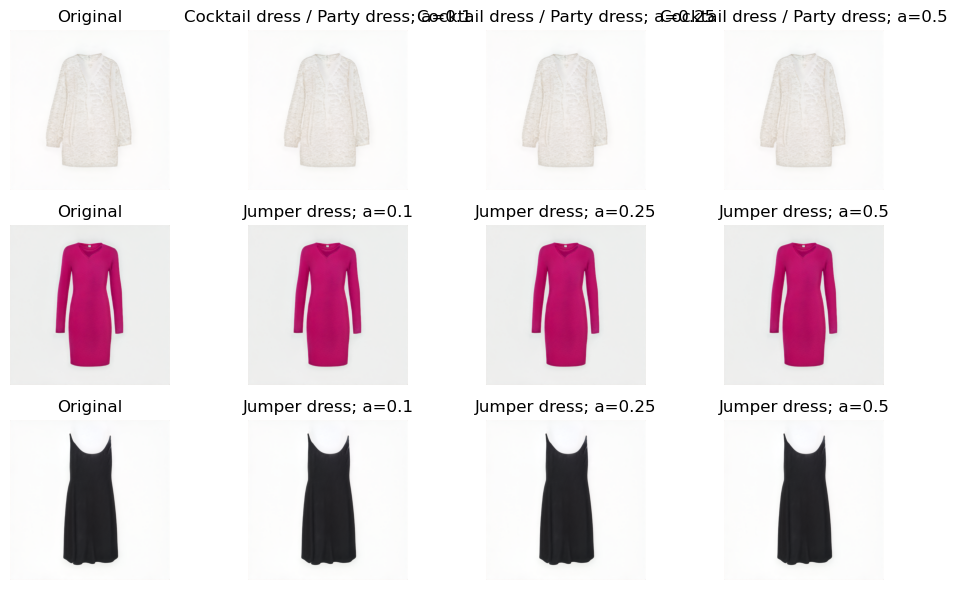

Step 250, Mean Losses in interval: 0.09983954578638077 | Mean Gradient Norm: 1.6918165683746338


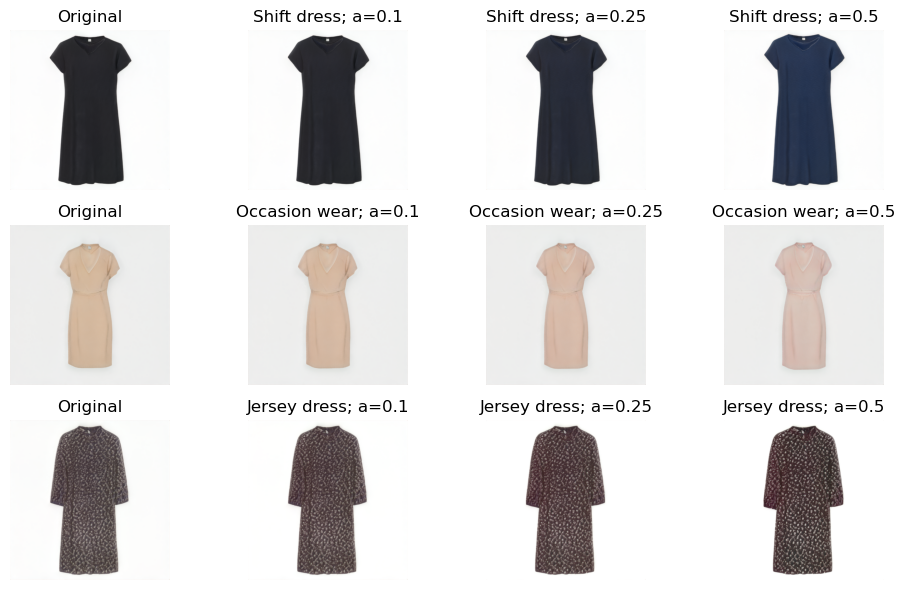

Step 500, Mean Losses in interval: 0.012000261805951595 | Mean Gradient Norm: 0.2805728316307068


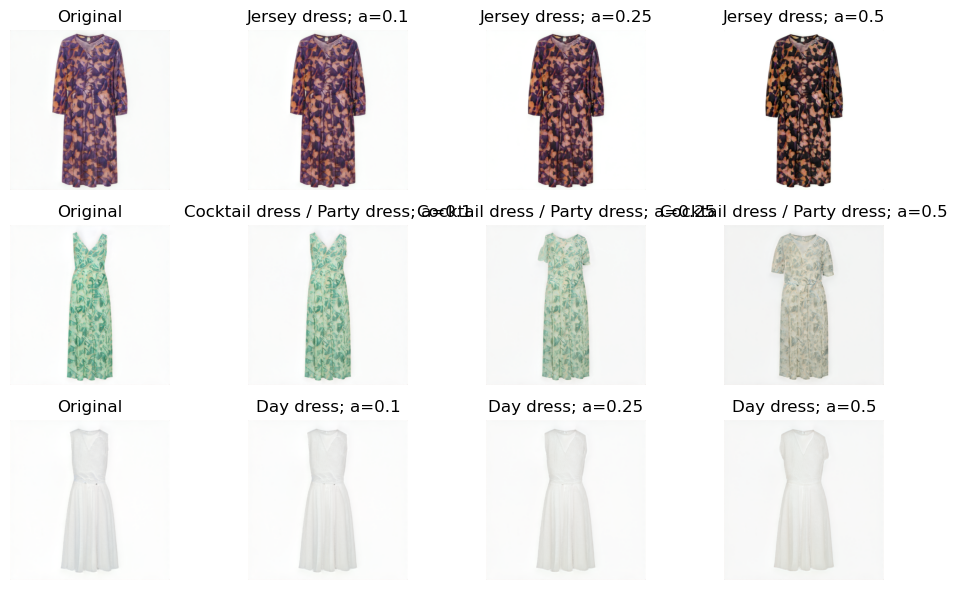

Step 750, Mean Losses in interval: 0.34559884667396545 | Mean Gradient Norm: 0.25400659441947937


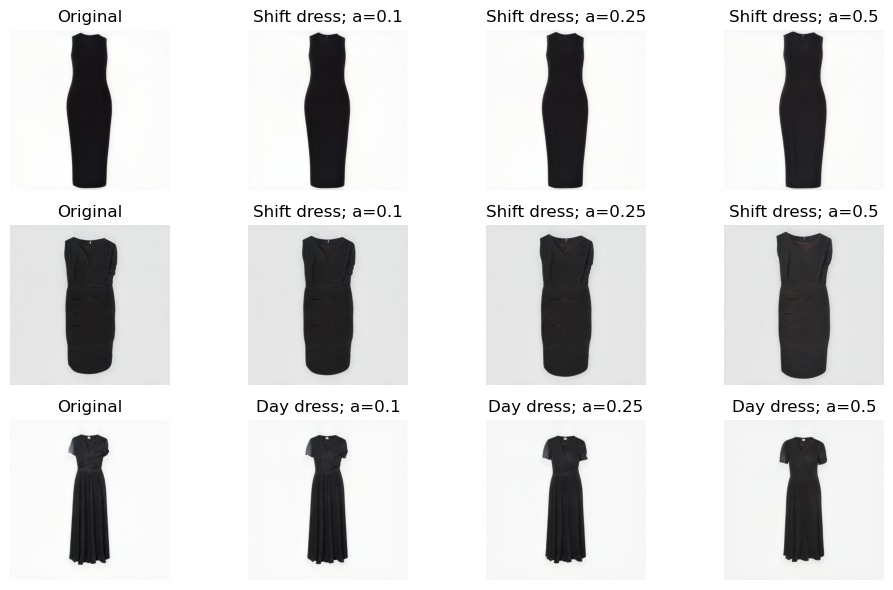

Step 1000, Mean Losses in interval: 0.09957528114318848 | Mean Gradient Norm: 0.05939272791147232


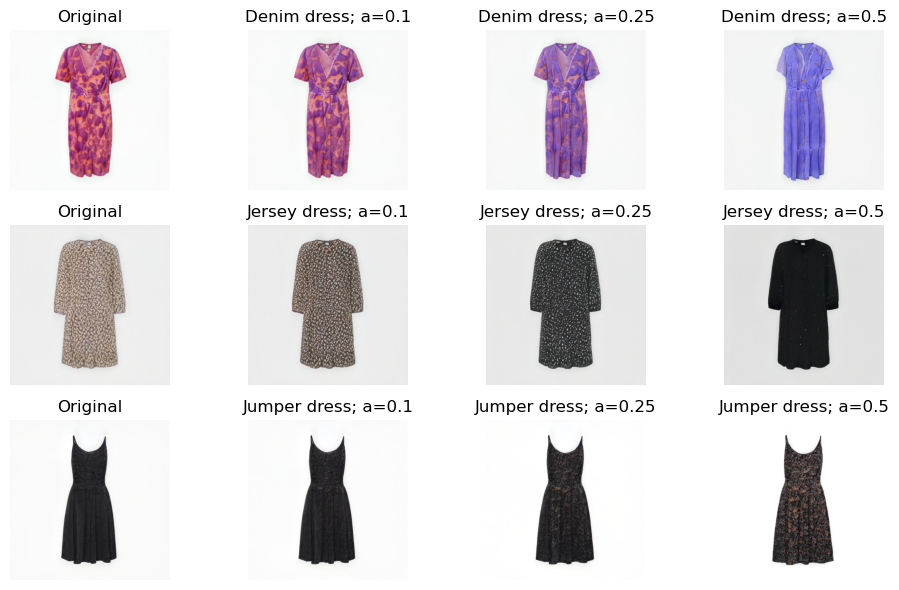

Step 1250, Mean Losses in interval: 0.1600000262260437 | Mean Gradient Norm: 1.3507470697504687e-08


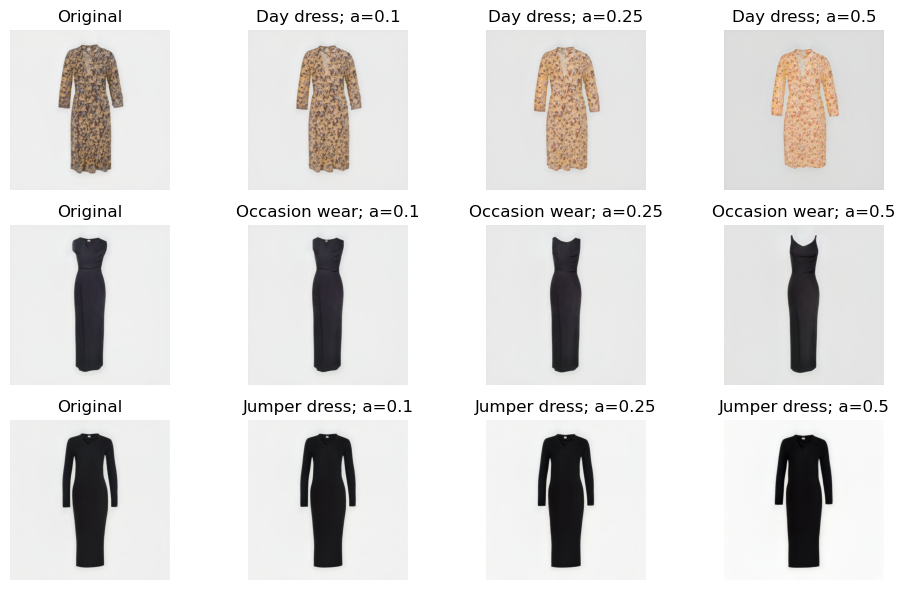

Step 1500, Mean Losses in interval: 0.002260894048959017 | Mean Gradient Norm: 0.12175906449556351


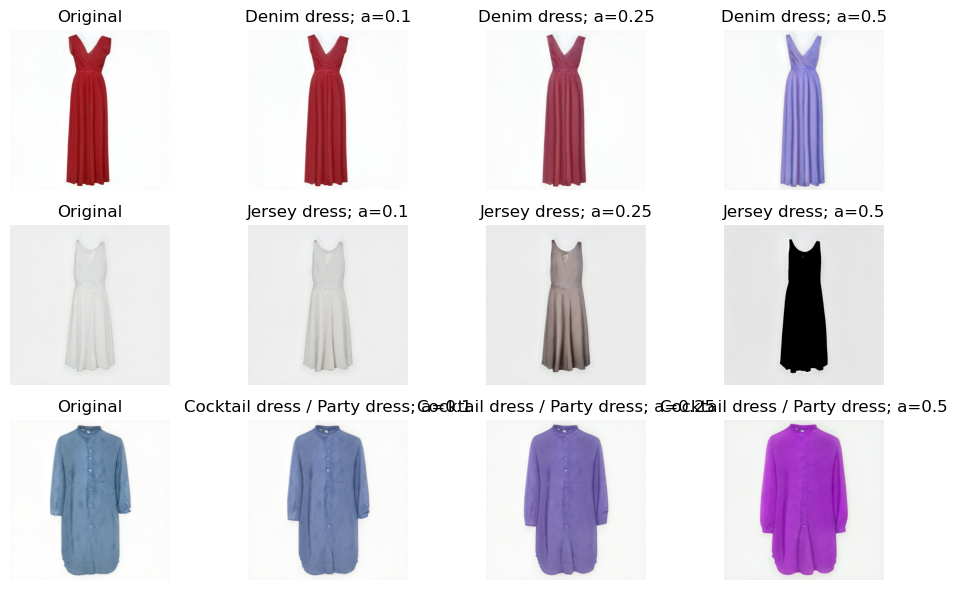

Step 1750, Mean Losses in interval: 0.05198323354125023 | Mean Gradient Norm: 0.09103398025035858


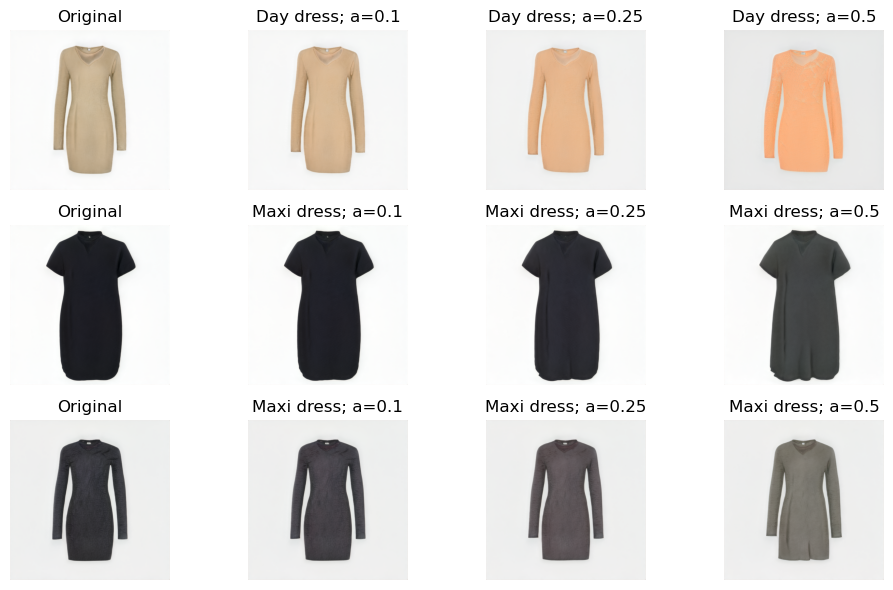

Step 2000, Mean Losses in interval: 2.9901750167482533e-05 | Mean Gradient Norm: 0.0009470484801568091


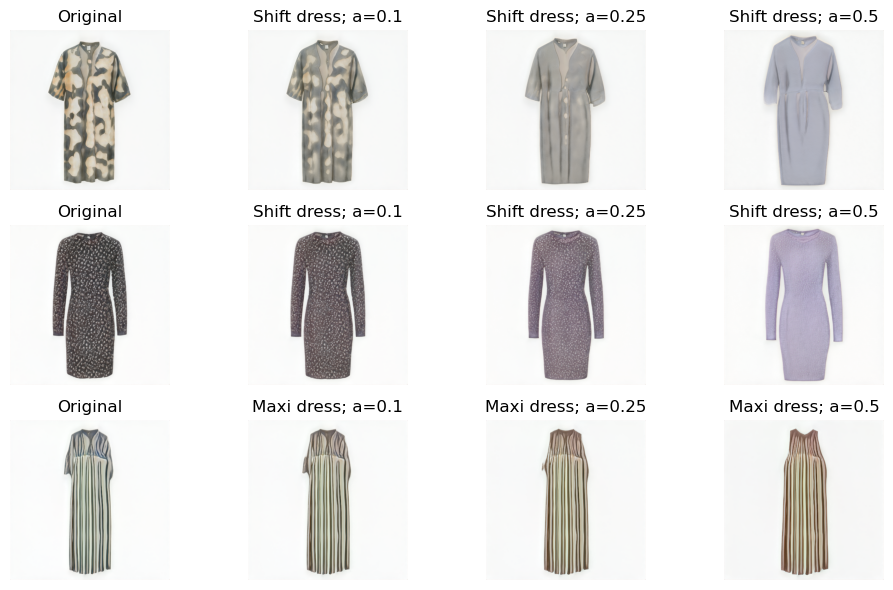

Step 2250, Mean Losses in interval: 0.018890440464019775 | Mean Gradient Norm: 0.2537291944026947


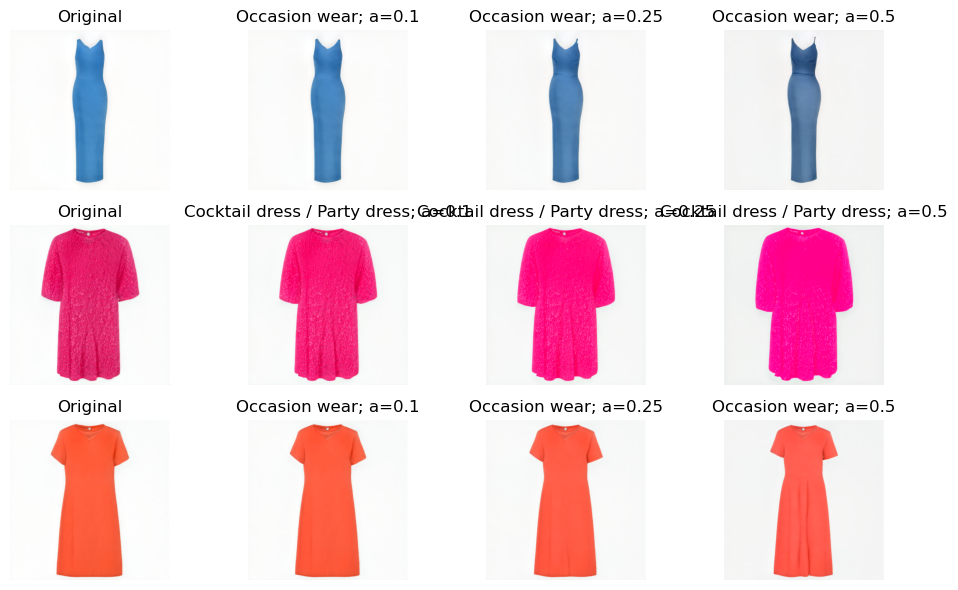

Step 2500, Mean Losses in interval: 0.08868963271379471 | Mean Gradient Norm: 0.007049910258501768


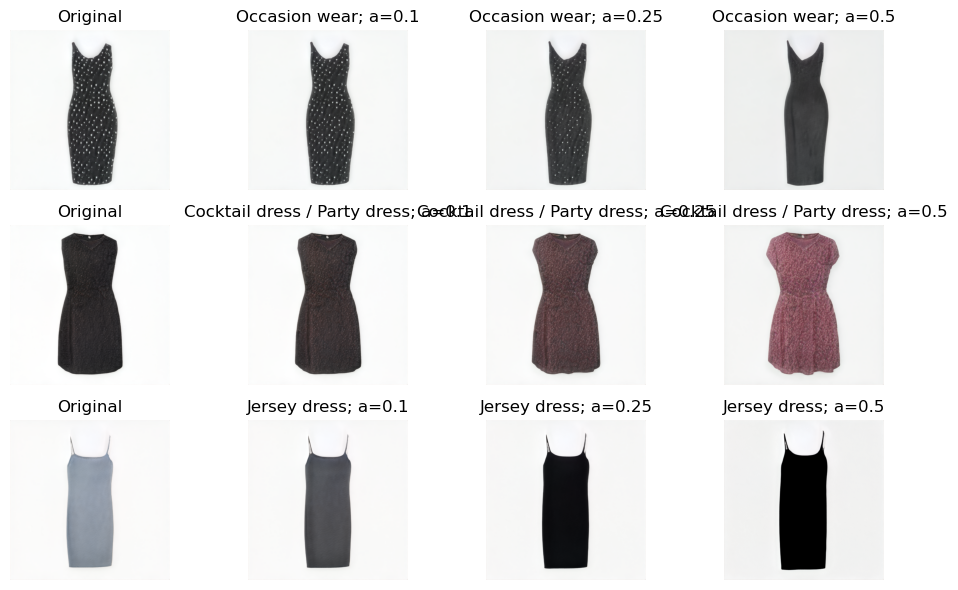

Step 2750, Mean Losses in interval: 0.7635610103607178 | Mean Gradient Norm: 0.017404861748218536


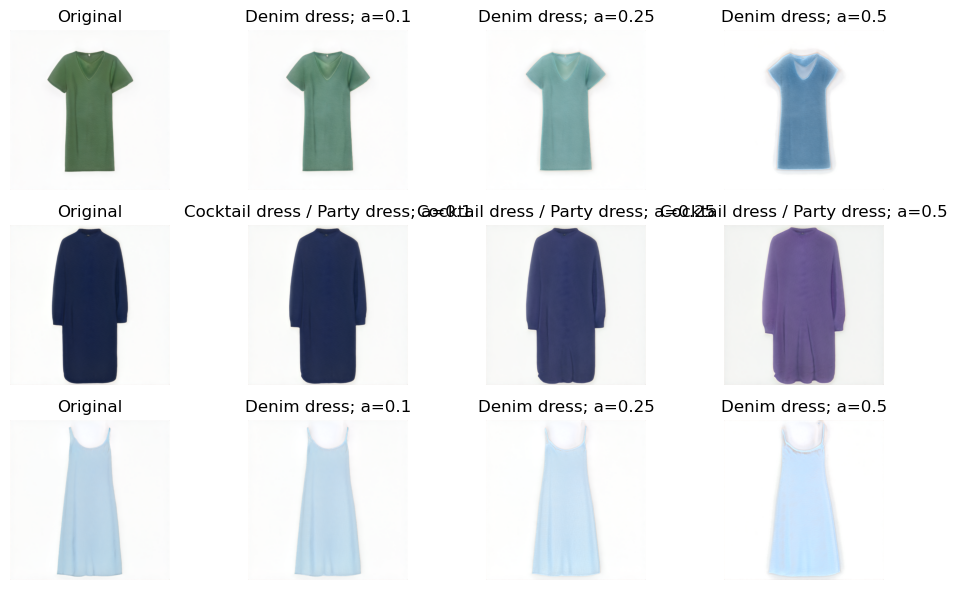

Step 3000, Mean Losses in interval: 0.07823818176984787 | Mean Gradient Norm: 0.4824162423610687


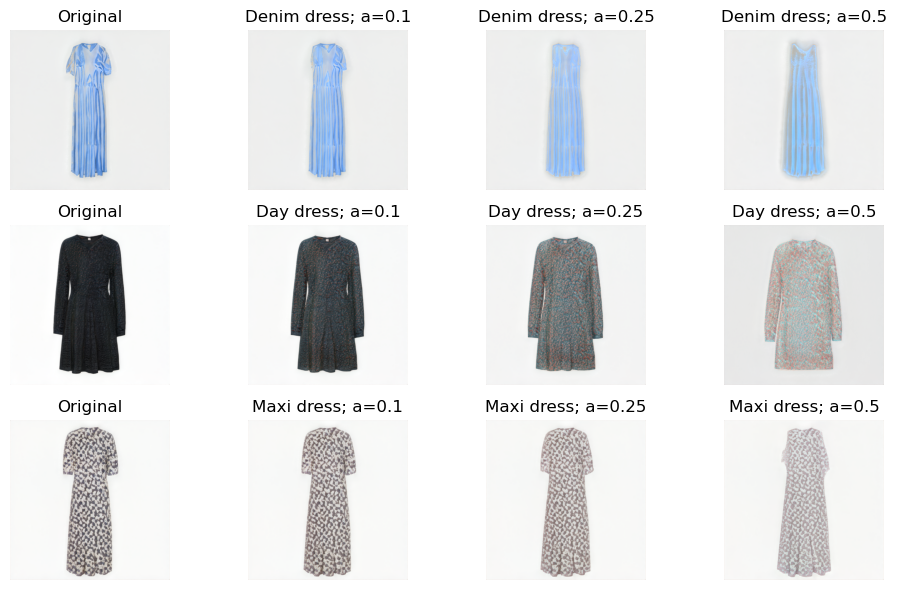

Step 3250, Mean Losses in interval: 0.03378457948565483 | Mean Gradient Norm: 0.3474593162536621


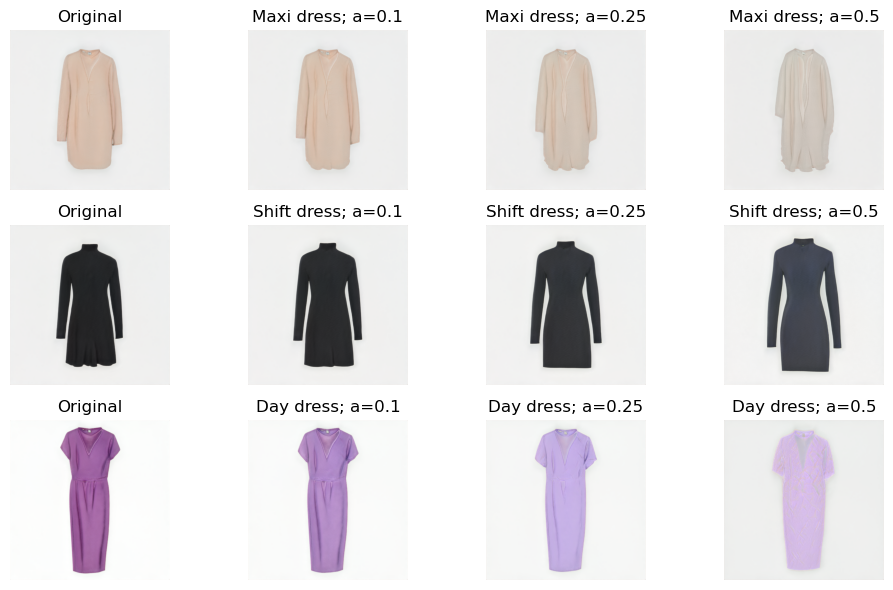

Step 3500, Mean Losses in interval: 0.004380177706480026 | Mean Gradient Norm: 0.043522316962480545


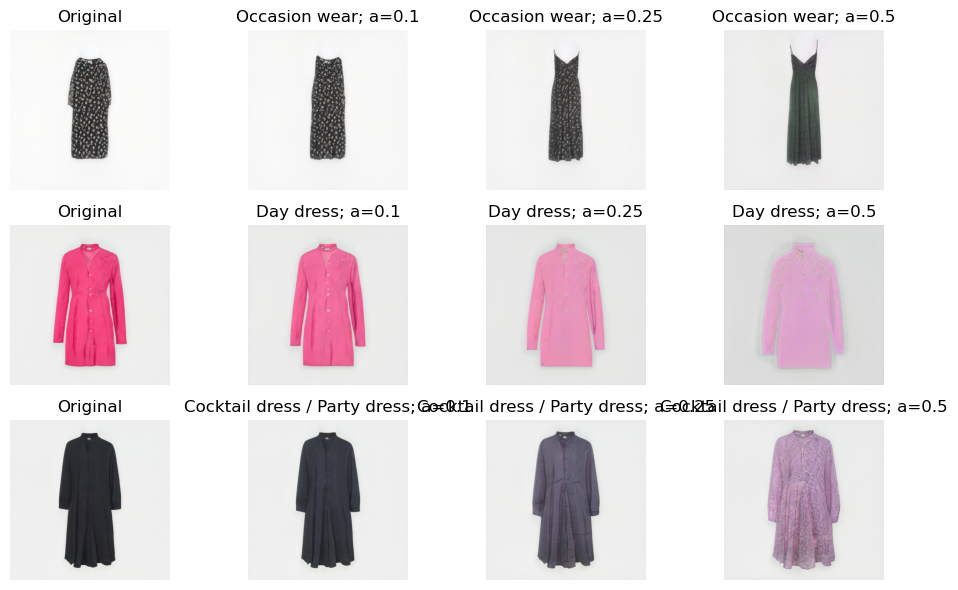

Step 3750, Mean Losses in interval: 0.10985115170478821 | Mean Gradient Norm: 0.17444060742855072


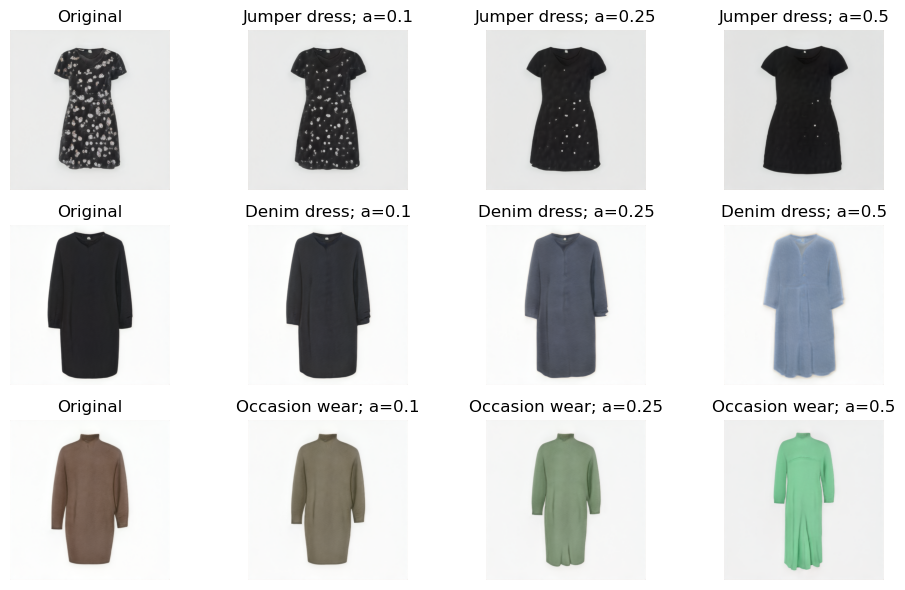

Step 4000, Mean Losses in interval: 0.16969101130962372 | Mean Gradient Norm: 3.1487255096435547


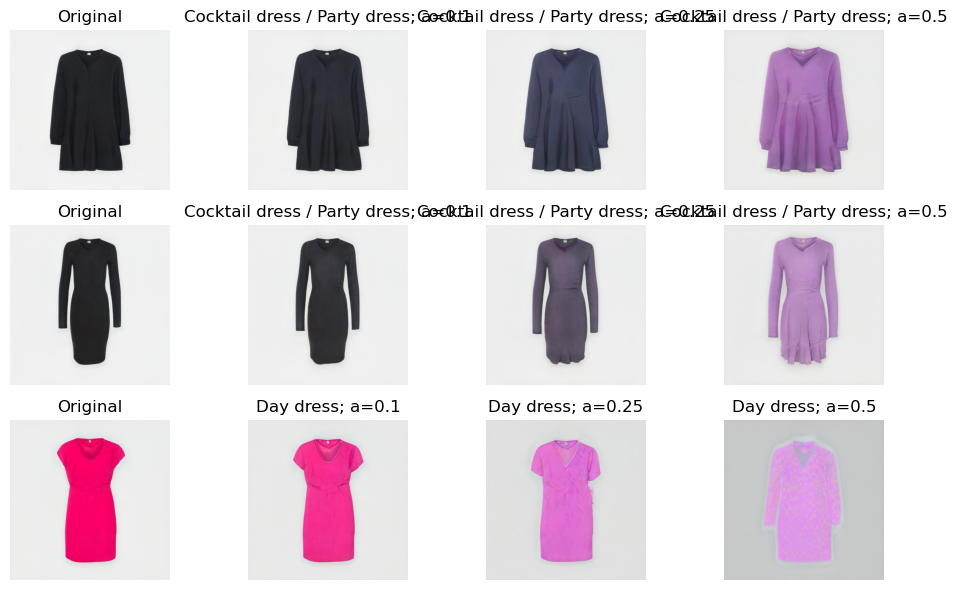

Step 4250, Mean Losses in interval: 0.2649843096733093 | Mean Gradient Norm: 0.09085915982723236


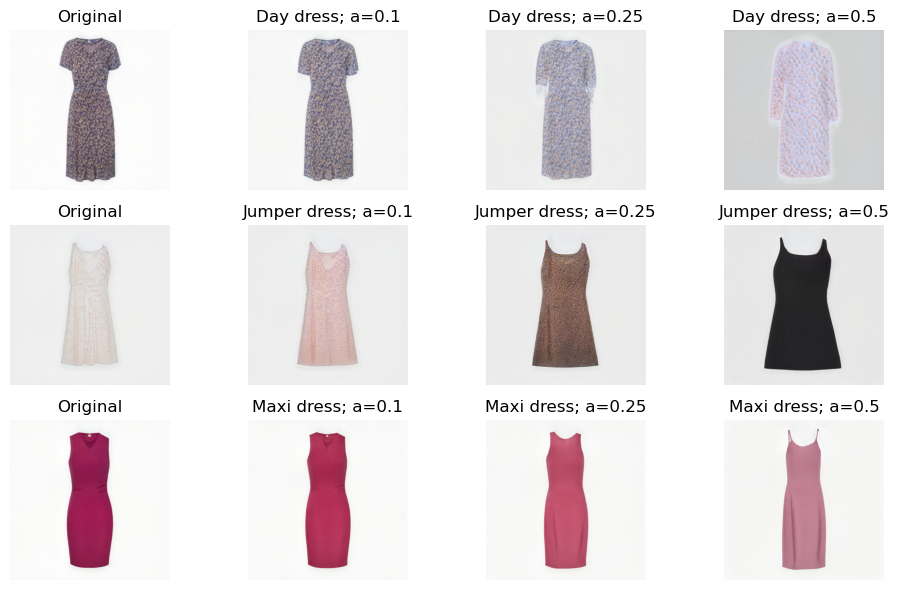

Step 4500, Mean Losses in interval: 2.710238788949937e-08 | Mean Gradient Norm: 5.1969692549391766e-08


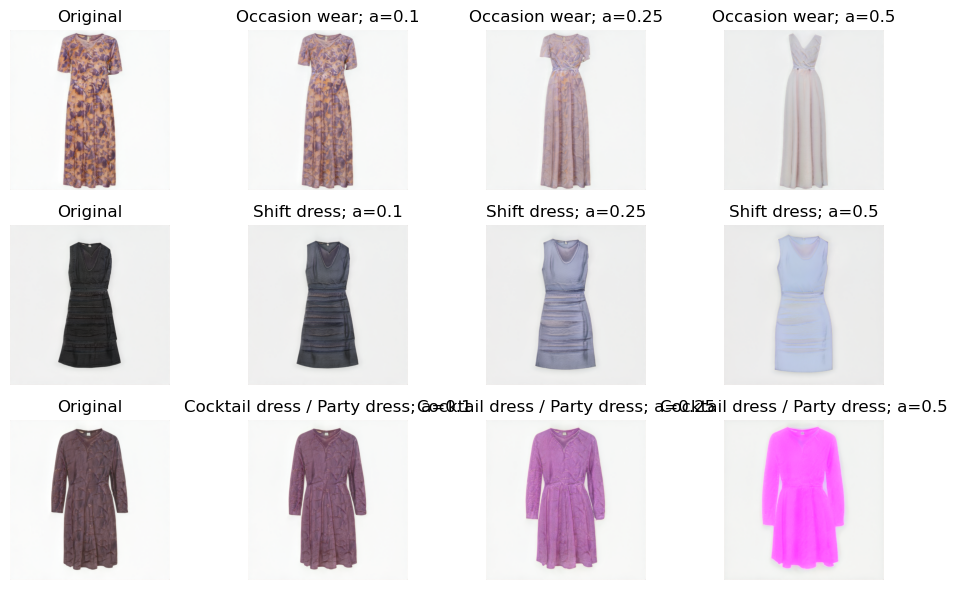

Step 4750, Mean Losses in interval: 0.0743672177195549 | Mean Gradient Norm: 0.2862197756767273


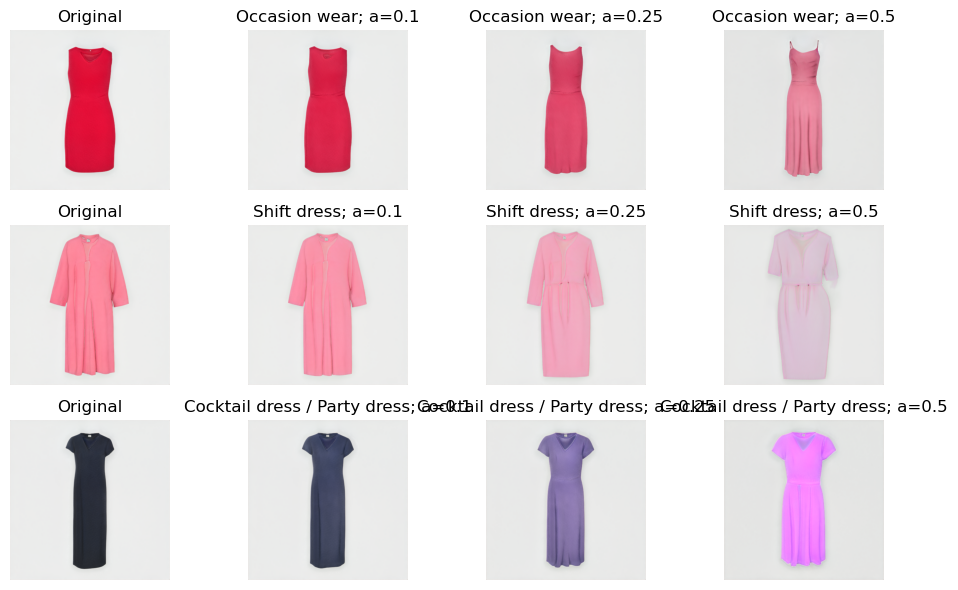

In [14]:
num_train_samples = 5000
print_interval = 250
save_interval = 500
accumulation_steps = 10
LR = 1e-2

save_directory = f"{DATA_PATH}/Models/Manipulations/GANalyze_Inspired/{target_feature}_{num_train_samples}_samples_{LR}_lr_{accumulation_steps}_accumulation_steps"
if not os.path.exists(save_directory):
    os.mkdir(save_directory)

# Initialize Directions Matrix as zeros
directions = torch.zeros([len(id2label), 16, 512], device=device, requires_grad=True)

# Set up optimizer and loss
optimizer = torch.optim.Adam([directions], lr=LR)
loss = nn.MSELoss(reduction='sum')

# Draw random training sample
samples = np.random.choice(range(0,len(latents)), num_train_samples)
for sample_num, sample in enumerate(tqdm(samples)):
    losses = []
    grad_norms = []
    # Sample random target class:
    target_class = np.random.choice(list(id2label.keys()))
    # Sample random alpha
    alpha = np.random.choice(np.round(np.arange(0.3, 1.1, 0.1),2))
    # Get latent
    latent = latents[sample]
    # Get class prediction for target class of unedited latent
    with io.capture_output() as captured:
        orig = G.synthesis(latent, noise_mode='const')
    orig_input_dino = dino_processor(orig).to(dino_device)
    orig_embedding = dino_model(orig_input_dino)['pooler_output'].to(device)
    orig_score = softmax(classifier(orig_embedding), dim = 1).squeeze(0)
    orig_score = orig_score[target_class]

    # Calculate Target score and handle non-existent probabilities
    if orig_score + alpha >= 1.0:
        alpha = 1.0 - orig_score
    elif orig_score + alpha  <= 0:
        alpha = -orig_score

    target_score = orig_score + alpha

    # Refine the directions using gradient descent on one image only
    new_latent = latent + alpha * directions[target_class]
    with io.capture_output() as captured:
        new_img = G.synthesis(new_latent, noise_mode='const')
    input_dino = dino_processor(new_img).to(dino_device)
    embedding = dino_model(input_dino)['pooler_output'].to(device)
    score = softmax(classifier(embedding), dim = 1).squeeze(0)
    score = score[target_class]


    # Calculate loss and propagate backwards
    l = loss(target_score, score)
    l.backward()
    losses.append(l.item())
    grad_norms.append(directions.grad.norm().item())

    if (sample_num + 1) % accumulation_steps == 0:
        optimizer.step()
        optimizer.zero_grad()
        
    if sample_num % print_interval == 0:
        print(f'Step {sample_num}, Mean Losses in interval: {np.mean(losses)} | Mean Gradient Norm: {np.mean(grad_norms)}')
        visualize_directions(directions, 3)
        losses = []
        grad_norms = []
    
    if sample_num % save_interval == 0:
        torch.save(directions, f"{save_directory}/directions_step_{sample_num}.pt")


### Test the Learned directions

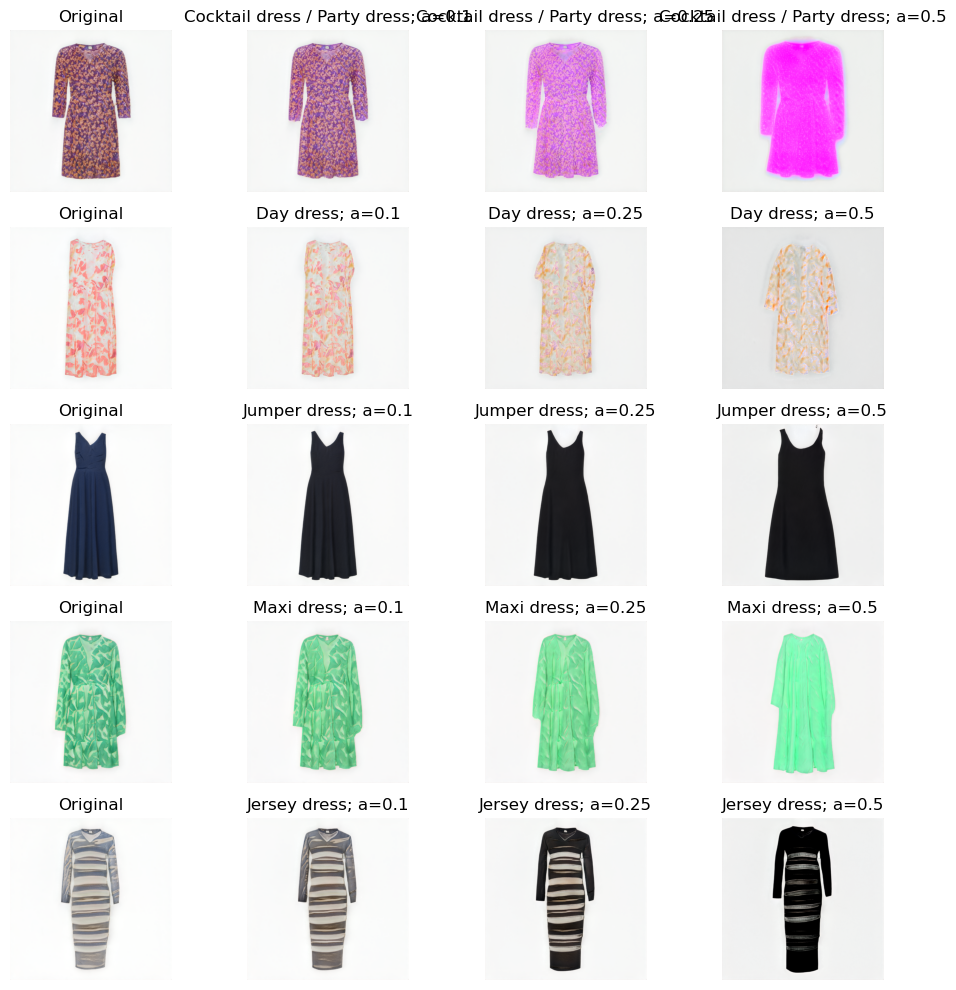

In [38]:
path = f'{DATA_PATH}/Models/Manipulations/GANalyze_Inspired/category_5000_samples_0.01_lr_10_accumulation_steps/directions_step_4500.pt'
directions = torch.load(path)
visualize_directions(directions, 5)

  0%|          | 0/8 [00:00<?, ?it/s]

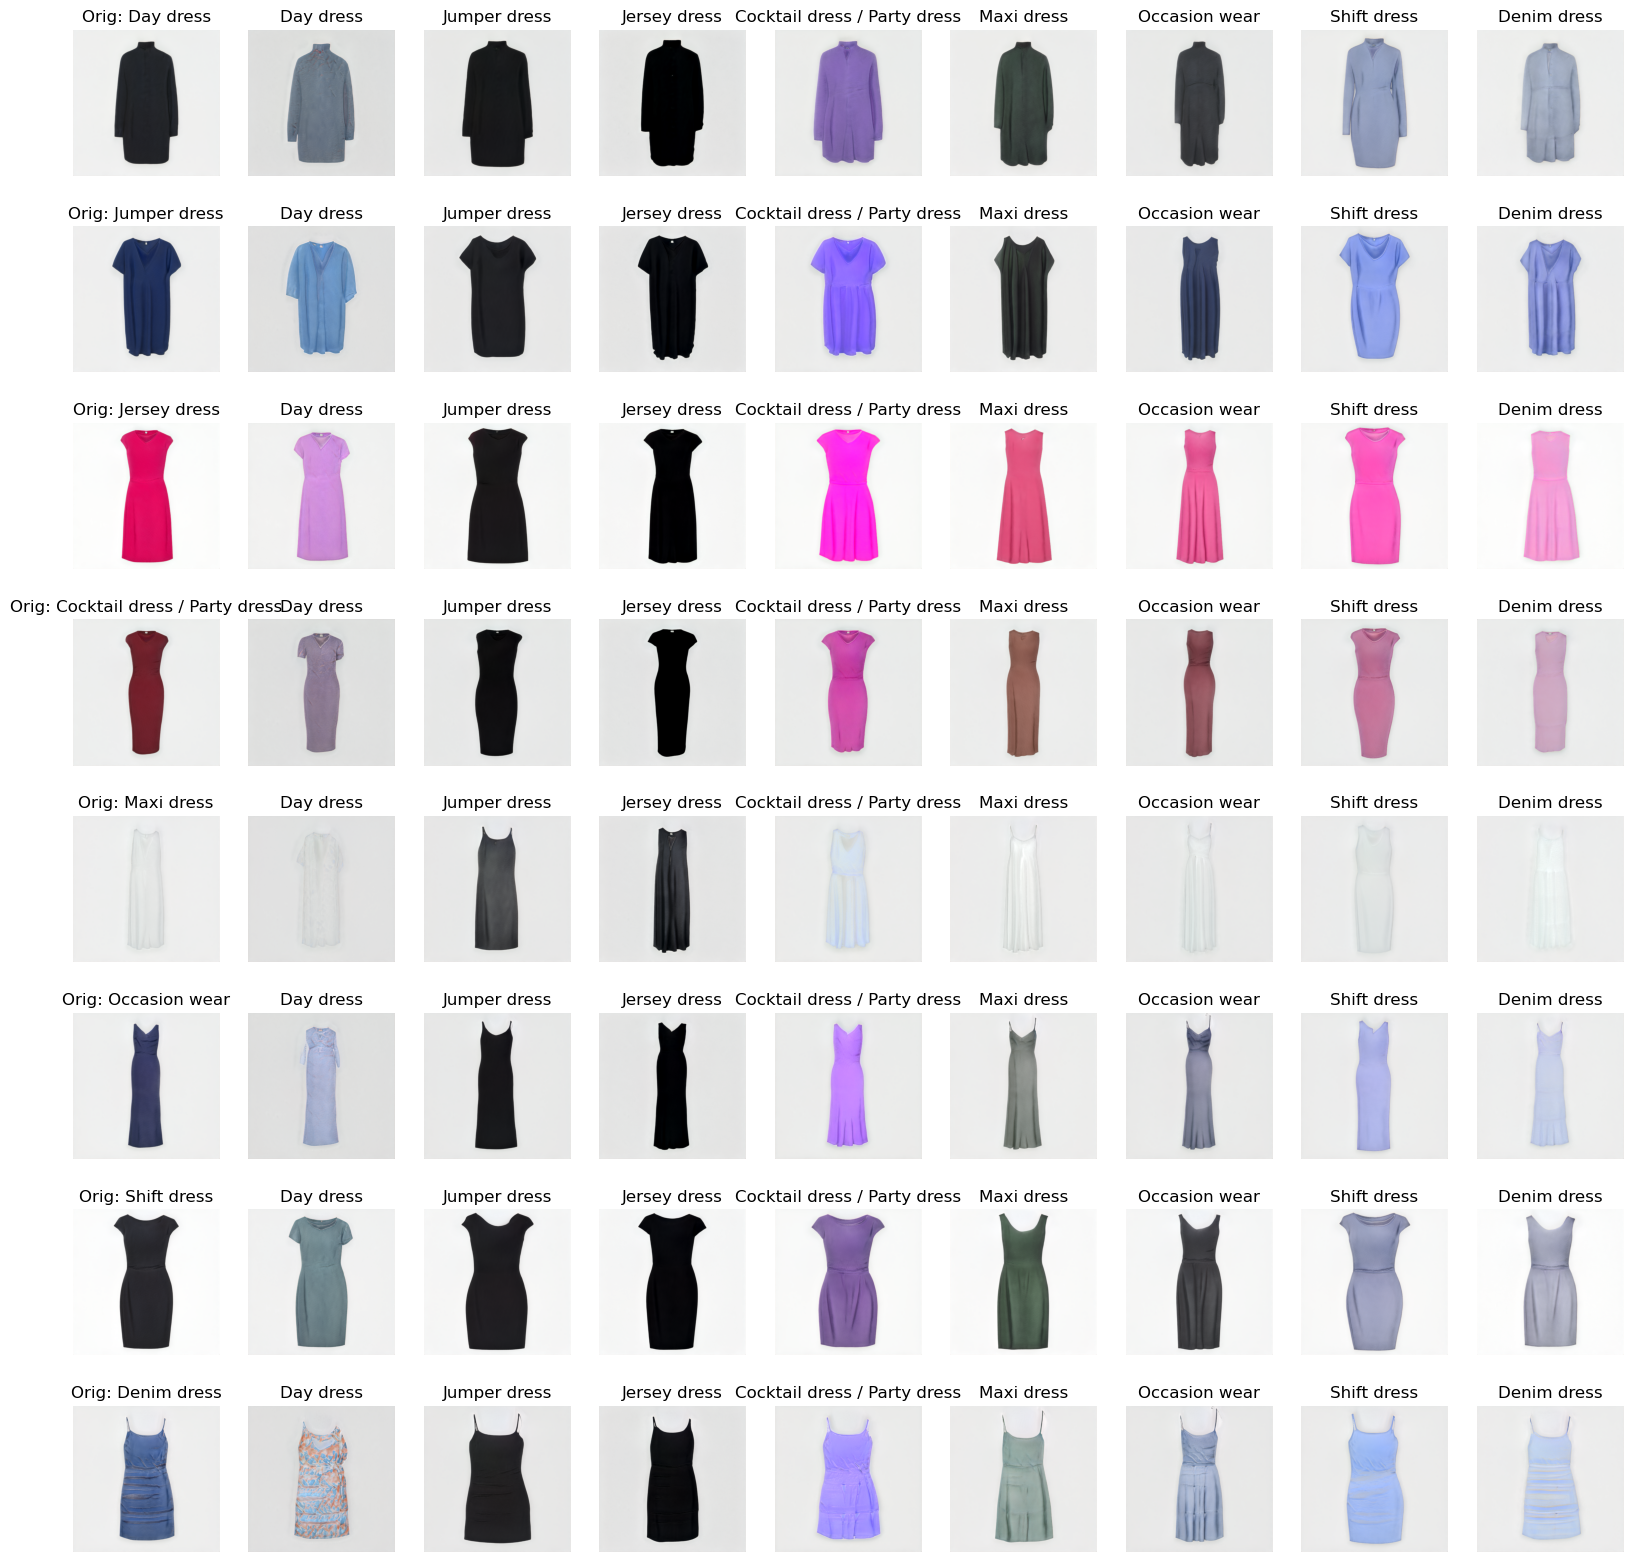

In [40]:
alpha = 0.3

fig, ax = plt.subplots(len(id2label), len(id2label)+1, figsize = (20,20))
for i, cat in enumerate(tqdm(id2label.values())):
    # Original Images
    reference = df[df.category == cat].sample(1).latent_idx.item()
    latent = latents[reference]
    with io.capture_output() as captured:
        ref_img = G.synthesis(latent, noise_mode = 'const')
    ref_img = plot_generated(ref_img)
    ax[i, 0].imshow(ref_img)
    ax[i, 0].axis('off')
    ax[i, 0].set_title(f"Orig: {cat}")

    for direction in id2label.keys():
        trans_latent = latent + alpha * directions[direction]
        with io.capture_output() as captured:
            img_gen = G.synthesis(trans_latent, noise_mode = 'const')
        img_gen = plot_generated(img_gen)
        ax[i, direction+1].imshow(img_gen)
        ax[i, direction+1].axis('off')
        ax[i, direction+1].set_title(id2label[direction])

plt.show()

### Torch Model Class -> Needs to be fixed

In [ ]:
import torch
import torch.nn as nn
from torch.nn.functional import softmax
import numpy as np

class Editor(nn.Module):
    def __init__(self, generator, dino_model, dino_processor, classifier, id2label, label2id):
        super(Editor, self).__init__()
        self.generator = generator
        self.dino_model = dino_model
        self.dino_processor = dino_processor
        self.classifier = classifier

        self.id2label = id2label
        self.label2id = label2id   
        self.num_classes = len(id2label)
        self.directions = nn.Parameter(torch.zeros(self.num_classes, 16, 512), requires_grad=True)
        self.alphas = np.arange(0,1,0.1)

    def forward(self, latent, class_idx=None, alpha = None):
        if class_idx == None:
            class_idx = torch.randint(0, self.num_classes, (1,), device=self.directions.device)
        
        if alpha == None:
            alpha = torch.tensor(np.round(np.random.choice(self.alphas),2), device=latent.device, dtype=torch.float32)
            print(alpha)
        # Processing for real image
        with io.capture_output() as captured:
            real_img = self.generator.synthesis(latent, noise_mode='const')
        real_dino_input = self.dino_processor(real_img).to(dino_model.device)
        real_dino_embedding = self.dino_model(real_dino_input)['pooler_output'].to(latent.device)
        real_scores = self.classifier(real_dino_embedding)
        real_probs = softmax(real_scores, dim=1).squeeze(0)
        real_class_prob = real_probs[class_idx]

        # Processing for transformed image
        transformed_latent = latent + alpha * self.directions[class_idx].to(latent.device)
        with io.capture_output() as captured:
            transformed_img = self.generator.synthesis(transformed_latent, noise_mode='const')
        transformed_dino_input = self.dino_processor(transformed_img).to(dino_model.device)
        transformed_dino_embedding = self.dino_model(transformed_dino_input)['pooler_output'].to(latent.device)
        transformed_scores = self.classifier(transformed_dino_embedding)
        transformed_probs = softmax(transformed_scores, dim=1).squeeze(0)
        transformed_class_prob = transformed_probs[class_idx]

        return real_class_prob, transformed_class_prob, class_idx, alpha


In [ ]:
k = 9876

latent = latents[k]
display(df[df.latent_idx == k])
gen_img = G.synthesis(latent, noise_mode='const')
gen_img = plot_generated(gen_img)
display(gen_img)

In [ ]:
# Assuming all components are properly setup and moved to the correct device

latent = latents[k]

editor = Editor(G, dino_model, dino_processor, classifier, id2label, label2id)
optimizer = torch.optim.Adam(editor.parameters(), lr=0.5)
criterion = nn.MSELoss(reduction='sum')

for i in range(20):
    optimizer.zero_grad()
    real_class_prob, transformed_class_prob, class_idx, alpha = editor(latent, class_idx = 0, alpha=1)
    target = torch.tensor(1.0, device=latent.device, dtype=torch.float32)
    loss = criterion(target, transformed_class_prob)

    loss.backward()
    optimizer.step()
    print(f"Step {i} (class: {class_idx}, alpha:{alpha}): Loss: {loss.item()} | Directions gradient norm {editor.directions.grad.norm()} | Class prob of gen: {transformed_class_prob.item()}")
    transformed = latent + 1 * editor.directions[0].to(latent.device)
    out_img = plot_generated(G.synthesis(transformed, noise_mode='const'))
    display(out_img.resize([124, 124]))


In [ ]:
transformed_latent = latent + 1 * editor.directions[0].to(latent.device)
out_img = plot_generated(G.synthesis(transformed_latent, noise_mode='const')).resize([512, 512])
out_img

In [ ]:
# Test the classification: 
dino_input = dino_processor(G.synthesis(transformed_latent, noise_mode='const')).to(dino_model.device)
dino_embedding = dino_model(dino_input)['pooler_output'].to(device)
scores = classifier(dino_embedding)
probs = softmax(scores, dim=1).squeeze(0)
probs